In [1]:
import numpy as np
import h5py
import illustris_python as il
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [2]:
path = "../data/TNG300-1/output"
snapidx = 99

header = il.groupcat.loadHeader(path, snapidx)

# load halos
fields = ["GroupFirstSub", "Group_M_Crit200", "Group_R_Crit200", "GroupVel"]
halos = il.groupcat.loadHalos(path, snapidx, fields=fields)

# load subhalos
fields = ["SubhaloFlag", "SubhaloGrNr", "SubhaloPos", "SubhaloLen", "SubhaloLenType", "SubhaloMassType", "SubhaloSFR", "SubhaloSpin", "SubhaloHalfmassRadType", "SubhaloMassInHalfRadType", "SubhaloStellarPhotometrics", "SubhaloVmax", "SubhaloVmaxRad"]
subhalos = il.groupcat.loadSubhalos(path, snapidx, fields=fields)

# read halo structure
path = "../data/TNG300-1/postprocessing/halo_structure/halo_structure_099.hdf5"
with h5py.File(path, "r") as f:
    GroupFlag = np.array(f["GroupFlag"])

    a_form = np.array(f["a_form"])
    concentration = np.array(f["c200c"])
    sigma = np.array(f["sigma_3D"])
    s = np.array(f["s"])
    q = np.array(f["q"])
    s_vel = np.array(f["s_vel"])
    q_vel = np.array(f["q_vel"])
    M_acc = np.array(f["M_acc_dyn"])
    E_s = np.array(f["E_s"])
    v_dm = np.array(f["Mean_vel"])
    f_mass_cen = np.array(f["f_mass_Cen"])
    R0p9 = np.array(f["R0p9"])


In [3]:
print(halos)

{'count': 17625892, 'GroupFirstSub': array([    0, 11748, 17908, ...,    -1,    -1,    -1], dtype=int32), 'Group_M_Crit200': array([104034.41,  88559.22,  69996.71, ...,      0.  ,      0.  ,
            0.  ], dtype=float32), 'Group_R_Crit200': array([1647.9259, 1561.8539, 1444.0035, ...,    0.    ,    0.    ,
          0.    ], dtype=float32), 'GroupVel': array([[ 296.78003  ,  122.684685 ,  -89.75425  ],
       [ 152.57509  ,  -40.34172  ,  -51.913128 ],
       [   1.1976243,  103.12467  ,  106.78151  ],
       ...,
       [ 139.75578  ,  228.32135  , -137.61148  ],
       [-219.87894  , -713.04645  , -759.01086  ],
       [  58.757706 ,   78.24492  ,   -1.1202759]], dtype=float32)}


In [4]:
n_tot = subhalos["count"]
subhalo_idx = np.zeros(n_tot, dtype=bool)

# halo properties are available 
subhalo_idx[halos["GroupFirstSub"][GroupFlag == 1]] = True  

# SubhaloFlag non-zero (zero means subhalo is not suitable for analysis)
subhalo_idx[subhalos["SubhaloFlag"] == 0] = False  

n_selected = sum(subhalo_idx)
print(n_selected)

419752


Get halo properties

In [5]:
# virial mass
halo_idx = subhalos["SubhaloGrNr"][subhalo_idx]
M_200 = halos["Group_M_Crit200"][halo_idx] * 1e10

# formation redshift
z_form = 1. / a_form[halo_idx] - 1.

# concentration
concentration = concentration[halo_idx]

# velocity dispersion
sigma = sigma[halo_idx]

# minor-to-major axis ratio
s = s[halo_idx]

q = q[halo_idx]
s_vel = s_vel[halo_idx]
q_vel = q_vel[halo_idx]
f_mass_cen = f_mass_cen[halo_idx]
R0p9 = R0p9[halo_idx]

# mass accretion rate
M_acc = M_acc[halo_idx]

# energy content
E_s = E_s[halo_idx]

# mean velocity of dm particles
v_dm = np.sqrt(v_dm[halo_idx,0]**2 + v_dm[halo_idx,1]**2 + v_dm[halo_idx,2]**2)

# spin parameter
R_200 = halos["Group_R_Crit200"][halo_idx]
Vvir = np.sqrt(43007.1 * halos["Group_M_Crit200"][halo_idx] / R_200)
spin = subhalos["SubhaloSpin"]
spin = np.sqrt(spin[subhalo_idx,0]**2 + spin[subhalo_idx,1]**2 + spin[subhalo_idx,2]**2)
spin = spin / (np.sqrt(2) * Vvir * R_200)


Get galaxy properties

In [6]:
# star formation rate
SFR = subhalos["SubhaloSFR"][subhalo_idx]

# stellar mass
stellar_mass = subhalos["SubhaloMassType"][subhalo_idx,4] * 1e10

# color
color_ui = subhalos["SubhaloStellarPhotometrics"][subhalo_idx,0] - subhalos["SubhaloStellarPhotometrics"][subhalo_idx,6]

# radius
halfmassradius = subhalos["SubhaloHalfmassRadType"][subhalo_idx,4]


In [7]:
# make dataframe and save data
d = {}
idx = (~np.isnan(concentration)) & (~np.isnan(M_acc)) & (SFR != 0) & (~np.isnan(z_form)) & (halfmassradius > 0)

d["M200c"] = np.log10(M_200[idx])
d["sigma"] = sigma[idx]
d["c200c"] = np.log10(concentration[idx])
d["z_form"] = z_form[idx]
d["s"] = s[idx]
d["q"] = q[idx]
d["M_acc"] = M_acc[idx]
d["E_s"] = np.log10(E_s[idx])
d["Mean_vel"] = v_dm[idx]
d["f_mass_cen"] = f_mass_cen[idx]
d["R0p9"] = R0p9[idx]
d["spin"] = spin[idx]

d["stellar_mass"] = np.log10(stellar_mass[idx])
d["radius"] = np.log10(halfmassradius[idx])
d["SFR"] = np.log10(SFR[idx])
d["color"] = color_ui[idx]

df = pd.DataFrame(d)

print("Selected subhalos:", df.shape[0])

df.to_csv("Data/IllustrisTNG300-1.csv", index=False)


Selected subhalos: 205500


In [11]:
# split into train/validation/test data
df_train, df_test = train_test_split(df, test_size=0.4)
df_val, df_test = train_test_split(df_test, test_size=0.5)

df_train.to_csv("Data/IllustrisTNG300-1-train.csv", index=False)
df_val.to_csv("Data/IllustrisTNG300-1-val.csv", index=False)
df_test.to_csv("Data/IllustrisTNG300-1-test.csv", index=False)

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(123300, 17)
(41100, 17)
(41100, 17)


Make plots of data

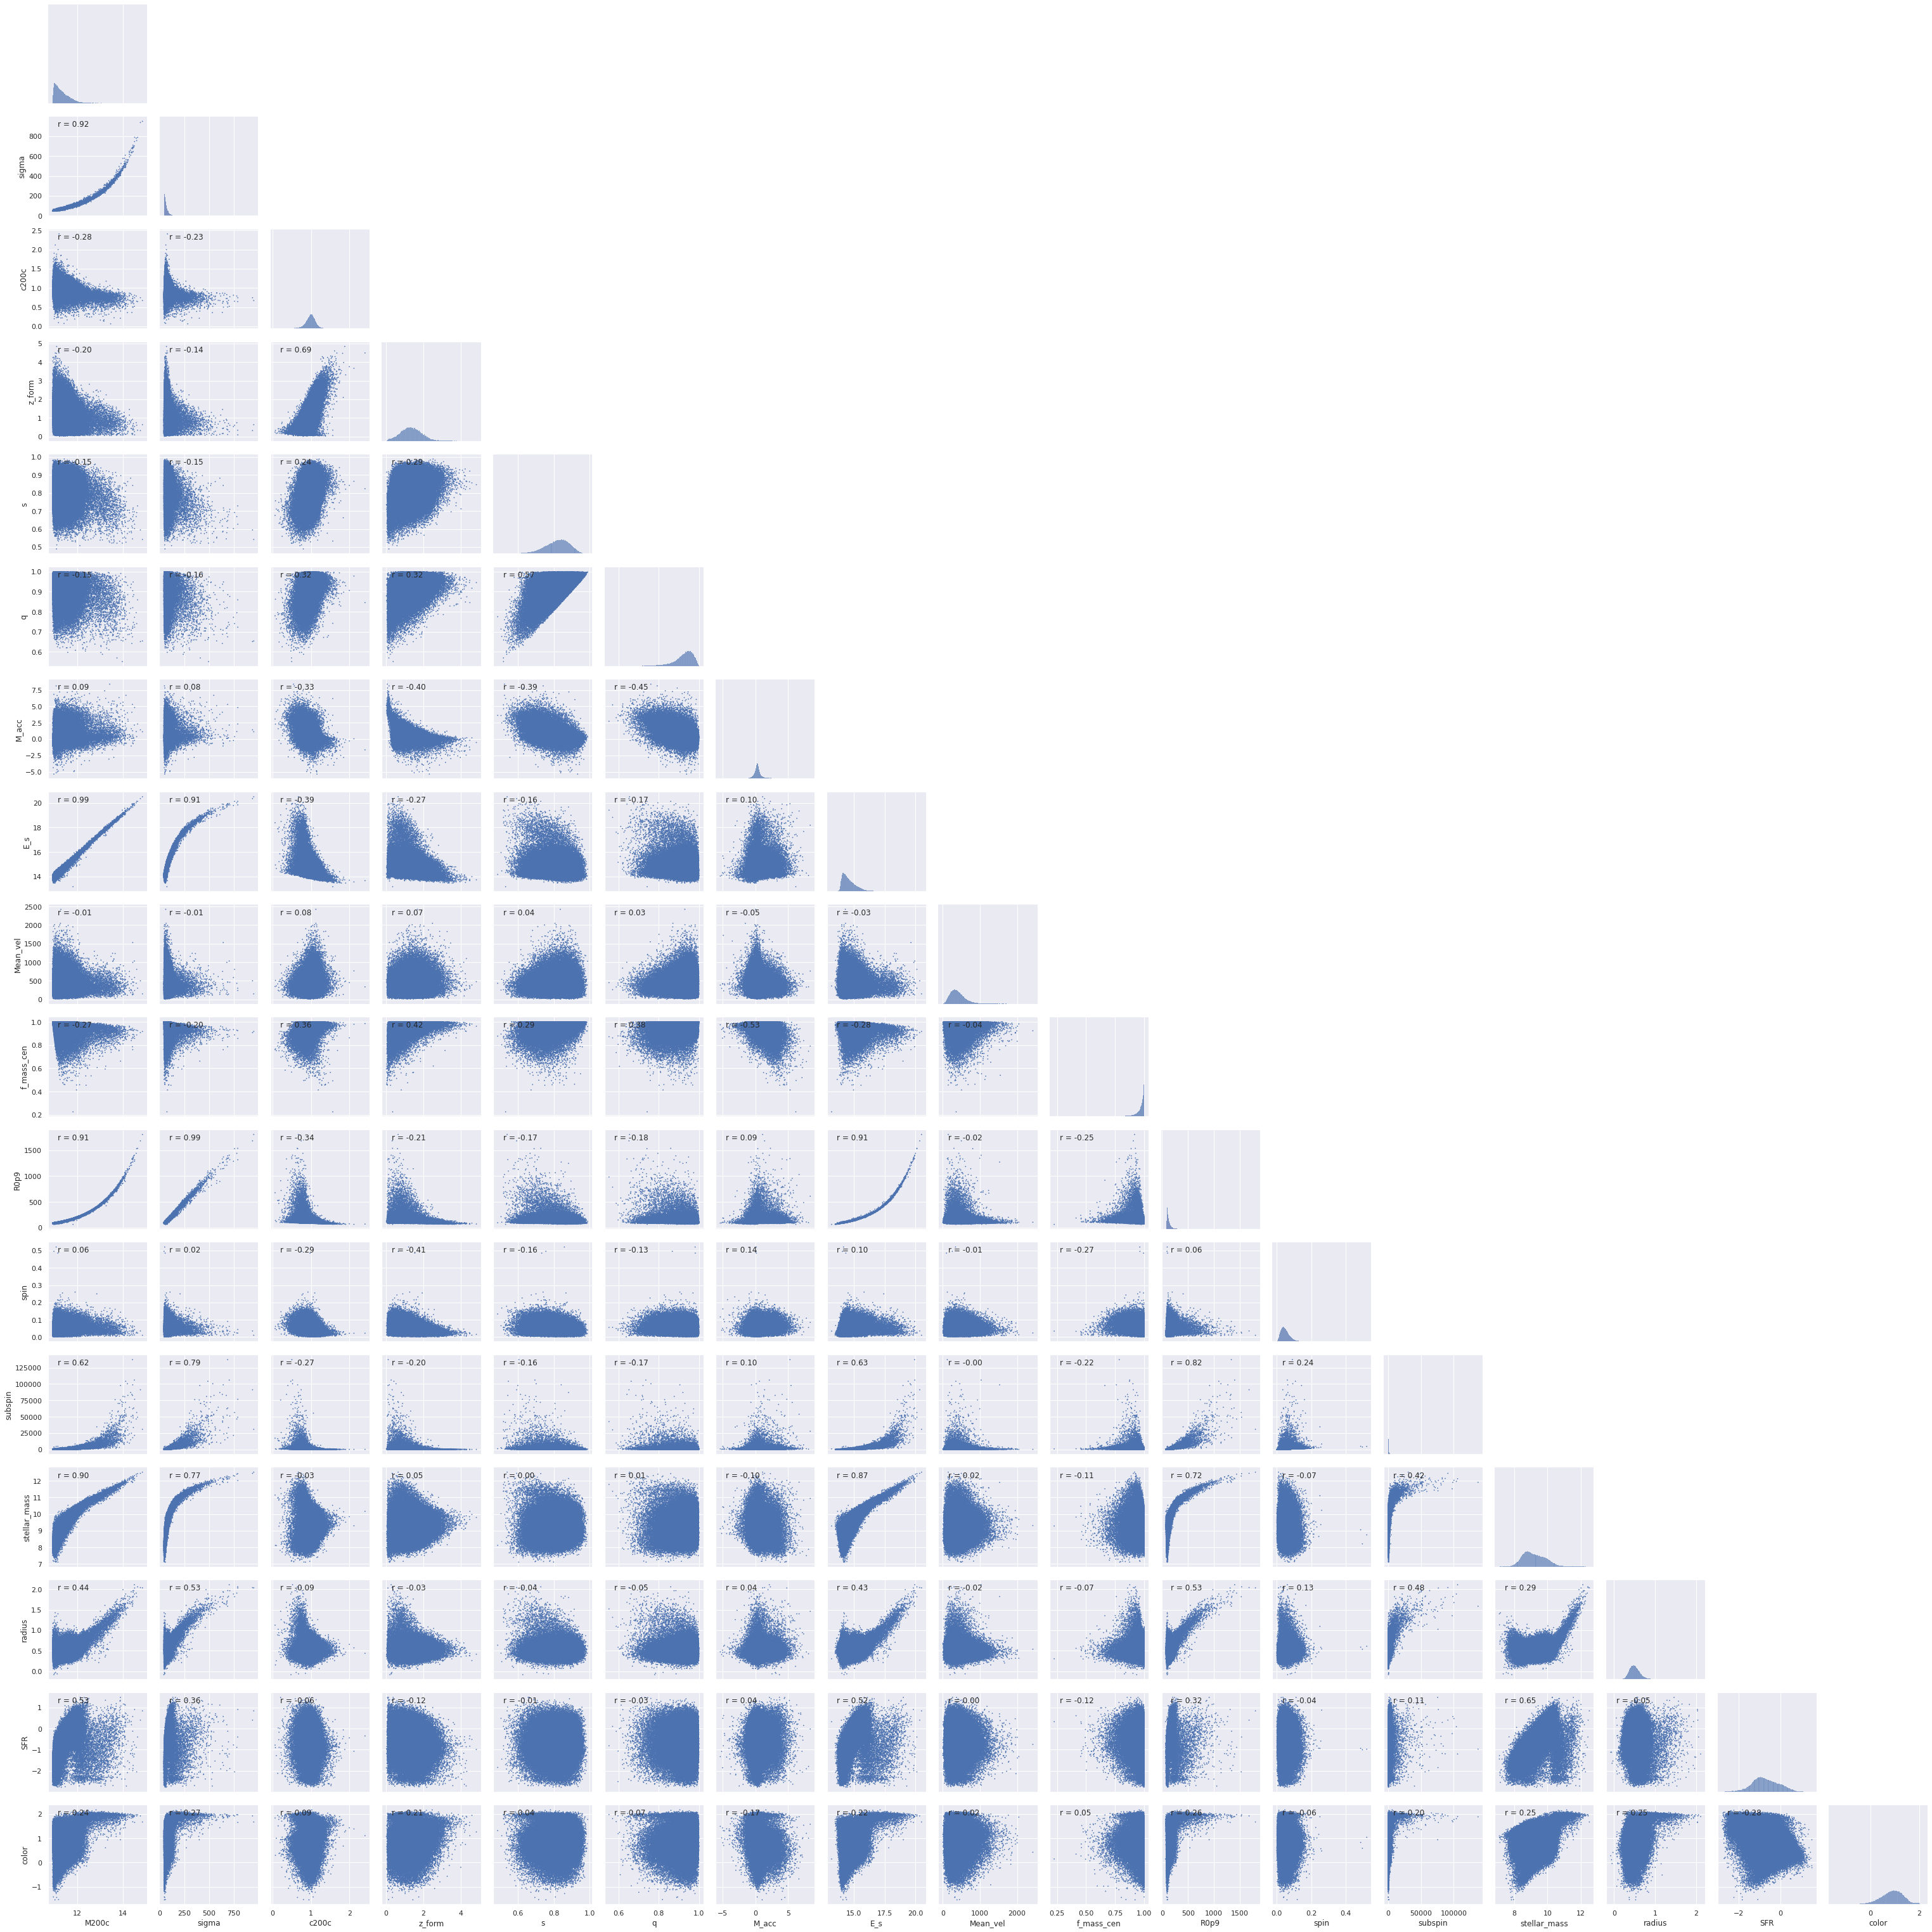

In [9]:

sns.set(rc={"figure.facecolor":"white"})

def corrfunc(x, y, ax=None, **kws):
    r= np.corrcoef(x, y)[0][1]
    ax = ax or plt.gca()
    ax.annotate(f'r = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)


fig  = sns.pairplot(df_train, corner=True, plot_kws=dict(s=3, edgecolor="none"))
fig.map_lower(corrfunc)
fig.fig.subplots_adjust(top=0.9)

plt.tight_layout()
fig.savefig("Figures/Data_pairplot.png")


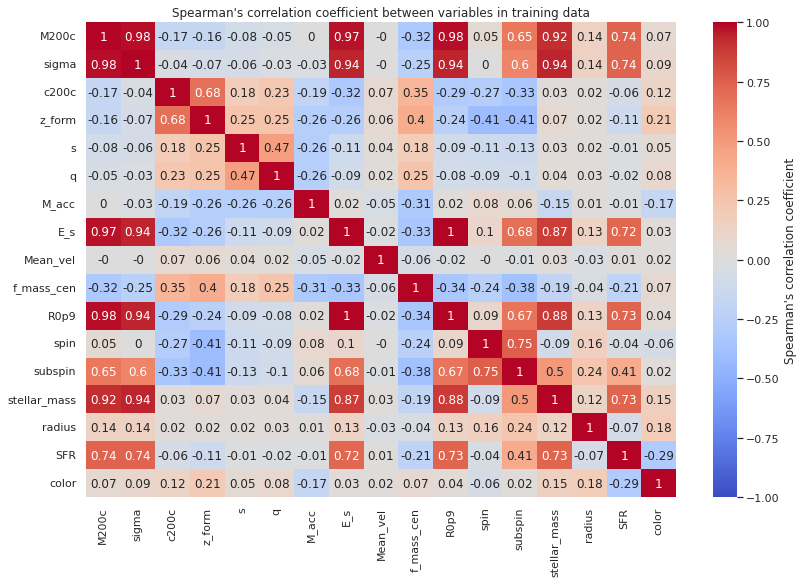

In [10]:
method = "spearman"

sns.set(rc={"figure.figsize":(11.7,8.27)})
sns.heatmap(df_train.corr(method=method).round(2), cmap="coolwarm", vmin=-1., vmax=1., cbar_kws={"label":f"{method.capitalize()}'s correlation coefficient"}, annot=True)

plt.title(f"{method.capitalize()}'s correlation coefficient between variables in training data")
plt.tight_layout()
plt.savefig(f"Figures/Data_correlations_{method}.png")